In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Video, display

In [10]:
def detect_rails(
    img_bgr,
    canny1=80,
    canny2=200,
    hough_threshold=120,
    min_line_length=100,
    max_line_gap=50,
    max_slope_degrees=20
):
    """
    1) Ищет 'горизонтальные' или слабо наклонённые линии через Хафа.
    2) Сортирует их по вертикали (y).
    3) Парами соседних линий (0-1, 2-3, ...) считает пути, заливает их разными цветами.
    4) Возвращает:
       - итоговое изображение (numpy array, BGR),
       - маску путей (uint8), в которой фон=0, пути = 1,2,3...,
       - количество путей (int).
    """

    # ШАГ 1. Считываем изображение
    h, w = img_bgr.shape[:2]

    # Сохраним копию для рисования
    out_bgr = img_bgr.copy()

    # Перевод в градации серого + Canny
    cv2.blur(img_bgr, (5, 5))
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, canny1, canny2)

    # ШАГ 2. Преобразование Хафа (версия Probabilistic)
    lines_p = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=hough_threshold,
        minLineLength=min_line_length,
        maxLineGap=max_line_gap
    )
    if lines_p is None:
        print("Не найдено линий HoughLinesP.")
        return None, None, 0

    # Фильтруем линии по углу (пример: допускаем наклон <= max_slope_degrees)
    acceptable_lines = []
    max_slope = np.tan(np.deg2rad(max_slope_degrees))
    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            continue  # вертикальная либо слишком крутая
        slope = abs(dy / dx)
        if slope <= max_slope:
            # Упорядочим, чтобы (x1, y1) был левее (x2, y2)
            if x2 < x1:
                x1, x2 = x2, x1
                y1, y2 = y2, y1
            acceptable_lines.append((x1, y1, x2, y2))

    if not acceptable_lines:
        print("Нет подходящих (полугоризонтальных) линий.")
        return None, None, 0

    # ШАГ 3. Группировка близких отрезков
    used = [False]*len(acceptable_lines)

    def avg_y(line):
        (xx1, yy1, xx2, yy2) = line
        return (yy1 + yy2)/2

    # Сортируем «сверху вниз»
    acceptable_lines.sort(key=avg_y)

    eps_y = 20  # "радиус" объединения по Y
    grouped_lines = []

    for i in range(len(acceptable_lines)):
        if used[i]:
            continue
        (x1_i, y1_i, x2_i, y2_i) = acceptable_lines[i]
        y_mid_i = (y1_i + y2_i) / 2

        group = [(x1_i, y1_i, x2_i, y2_i)]
        used[i] = True

        for j in range(i+1, len(acceptable_lines)):
            if used[j]:
                continue
            (x1_j, y1_j, x2_j, y2_j) = acceptable_lines[j]
            y_mid_j = (y1_j + y2_j) / 2
            if abs(y_mid_j - y_mid_i) < eps_y:
                group.append((x1_j, y1_j, x2_j, y2_j))
                used[j] = True

        # Сливаем группу в одну "среднюю" линию
        xs = []
        ys = []
        for (xa, ya, xb, yb) in group:
            xs.extend([xa, xb])
            ys.extend([ya, yb])
        x_min = min(xs)
        x_max = max(xs)
        y_mean = np.mean(ys)
        grouped_lines.append((int(x_min), int(y_mean), int(x_max), int(y_mean)))

    # Сортируем итоговые линии «сверху вниз»
    def line_y_mean(line):
        (xx1, yy1, xx2, yy2) = line
        return (yy1 + yy2)/2

    grouped_lines.sort(key=line_y_mean, reverse=True)

    # ШАГ 4. Заливаем участки (каждые 2 линии = 1 путь)
    overlay = out_bgr.copy()

    # Создаём маску путей (h, w), фон=0
    path_mask = np.zeros((h, w), dtype=np.uint8)

    colors = [
        (0,0,255),    # красный
        (0,255,0),    # зелёный
        (255,0,0),    # синий
        (0,255,255),  # жёлтый
        (255,0,255),  # фиолетовый
        (255,255,0),  # голубой
    ]

    alpha = 0.3

    num_paths = (len(grouped_lines) // 2)
    path_index = 0

    for i in range(0, len(grouped_lines) - 1, 2):
        path_index += 1
        (x1a, y1a, x2a, y2a) = grouped_lines[i]
        (x1b, y1b, x2b, y2b) = grouped_lines[i+1]

        ya = (y1a + y2a)//2
        yb = (y1b + y2b)//2
        y_top = min(ya, yb)
        y_bot = max(ya, yb)

        color = colors[i % len(colors)]

        pts = np.array([
            [0, y_top],
            [w, y_top],
            [w, y_bot],
            [0, y_bot]
        ], dtype=np.int32)

        # 1) Закрашиваем overlay цветом
        cv2.fillPoly(overlay, [pts], color)

        # 2) Заполняем path_mask индексом пути
        cv2.fillPoly(path_mask, [pts], path_index)

    # Смешиваем overlay и исходное (с прозрачностью alpha)
    cv2.addWeighted(overlay, alpha, out_bgr, 1 - alpha, 0, out_bgr)

    # ШАГ 5. Рисуем линии + подписи
    for idx, (x1, y1, x2, y2) in enumerate(grouped_lines):
        cv2.line(out_bgr, (x1, y1), (x2, y2), (255, 255, 255), 2)
        label = f"Rail {idx+1}"
        cv2.putText(
            out_bgr,
            label,
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255, 255, 255),
            2
        )

    # Возвращаем:
    # 1) Итоговое изображение (BGR) как np.array
    # 2) Маску путей (uint8)
    # 3) Количество путей
    return out_bgr, path_mask, num_paths

Shape of final_image_bgr: (473, 850, 3)
Shape of mask: (473, 850) unique values: [0 1 2]
Number of paths: 2


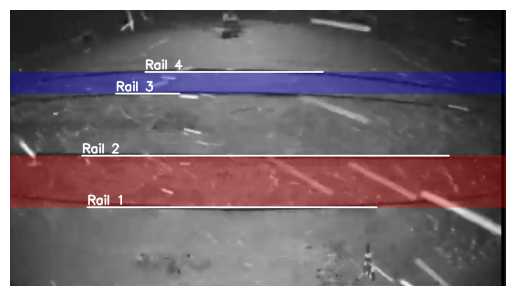

In [11]:
img_bgr = cv2.imread("../data/raw/empty_rails.png")


final_image_bgr, mask, count = detect_rails(img_bgr)
print("Shape of final_image_bgr:", final_image_bgr.shape)
print("Shape of mask:", mask.shape, "unique values:", np.unique(mask))
print("Number of paths:", count)

# Если нужно посмотреть результат в Jupyter:
plt.imshow(cv2.cvtColor(final_image_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:

def process_video(video_path, path_mask, output_video="output.mp4", alpha=0.05,threshold=2):
    """
    1) Получает на вход path_mask (одноканальный numpy-массив, где 0=фон, 1..N=пути).
    2) Считывает видео, для каждого кадра (только первые 10с) считает оптический поток (Farneback).
    3) Для каждого пути (индекс маски != 0) собирает векторы потока, сглаживает их по времени.
    4) Рисует стрелку и/или текст на кадре (показывая сглаженное направление и скорость потока).
    5) Записывает обработанное видео в output_video.
    6) Возвращает путь к результирующему файлу.
    """

    # === Шаг 0: Инициализация видео ===
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Не удалось открыть видео:", video_path)
        return None

    # Общее число кадров и FPS
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    vid_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    vid_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Ограничиваемся 10 секундами
    max_frames_10sec = int(fps * 50)  # столько кадров приходится на 10с
    max_frames_to_process = min(total_frames, max_frames_10sec)

    # Проверим, совпадают ли размеры video (w,h) и path_mask
    mask_h, mask_w = path_mask.shape[:2]
    if (mask_w != vid_w) or (mask_h != vid_h):
        print("Предупреждение: размеры маски и видео не совпадают! Масштабируем маску...")
        path_mask = cv2.resize(path_mask, (vid_w, vid_h), interpolation=cv2.INTER_NEAREST)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (vid_w, vid_h))

    # Считываем первый кадр
    ret, prev_frame = cap.read()
    if not ret:
        print("Видео пустое или ошибка чтения.")
        cap.release()
        out.release()
        return None

    # Переводим в grayscale для оптического потока
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Параметры оптического потока Farneback
    flow_params = dict(
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )

    # Собираем список ID путей (кроме 0 - фон)
    path_ids = sorted(set(path_mask.flatten()) - {0})
    print("Обнаруженные пути в маске:", path_ids)

    # === Сглаживание: сохраняем предыдущие значения dx, dy для каждого пути ===
    smoothed_flow = {pid: {"dx": 0, "dy": 0} for pid in path_ids}

    # === Основной цикл (только первые max_frames_to_process - 1 итераций) ===
    for _ in tqdm(range(max_frames_to_process - 1), desc="Processing frames"):
        ret, frame = cap.read()
        if not ret:
            break  # дошли до конца (меньше кадров, чем ожидалось?)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # === Оптический поток между prev_gray -> gray ===
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, **flow_params)
        # flow[...,0] = dx, flow[...,1] = dy

        output_frame = frame.copy()

        # === Для каждого пути считаем среднее dx, dy и сглаживаем ===
        path_flows = {}
        for pid in path_ids:
            region_mask = (path_mask == pid)

            dx_region = flow[..., 0][region_mask]
            dy_region = flow[..., 1][region_mask]

            if len(dx_region) < 10:
                # Слишком мало пикселей, пропускаем
                continue

            mean_dx = np.mean(dx_region)
            mean_dy = np.mean(dy_region)

            # Сглаживаем с предыдущими значениями
            smoothed_dx = alpha * mean_dx + (1 - alpha) * smoothed_flow[pid]["dx"]
            smoothed_dy = alpha * mean_dy + (1 - alpha) * smoothed_flow[pid]["dy"]

            # Сохраняем сглаженные значения для следующего кадра
            smoothed_flow[pid]["dx"] = smoothed_dx
            smoothed_flow[pid]["dy"] = smoothed_dy

            # Рассчитываем модуль скорости
            mag = np.sqrt(smoothed_dx**2 + smoothed_dy**2)
            path_flows[pid] = mag

            # Находим boundingRect области, чтобы где-то рисовать
            region_uint8 = region_mask.astype(np.uint8)
            x, y, w_rect, h_rect = cv2.boundingRect(region_uint8)
            cx = x + w_rect // 2
            cy = y + h_rect // 2

            # Рисуем стрелку
            tip_x = int(cx + smoothed_dx * 10)
            tip_y = int(cy + smoothed_dy * 10)
            color = (0, 255, 0)  # зелёный
            cv2.arrowedLine(output_frame, (cx, cy), (tip_x, tip_y), color, 2, tipLength=0.3)

            # Текст
            text_str = f"Path {pid}: dx={smoothed_dx:.1f}, dy={smoothed_dy:.1f}, mag={mag:.1f}"
            cv2.putText(output_frame, text_str, (x, max(y-5, 0)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # === Логика определения пути ===
        detected_path = None
        for pid in path_ids:
            if path_flows.get(pid, 0) > threshold:
                detected_path = pid
                break  # Прерываем, чтобы отдать приоритет ближнему пути

        if detected_path:
            text_str = f"Train detected on Path {detected_path}"
            cv2.putText(output_frame, text_str, (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0, 0, 255), 2)
            
        # Записываем кадр
        out.write(output_frame)

        # Подготовка к след. кадру
        prev_gray = gray

    cap.release()
    out.release()
    return output_video

In [56]:
video_file = "../data/raw/near.mp4"
output_file = "../data/processed/near.mp4"

processed_video_path = process_video(video_file, mask, output_file)

Предупреждение: размеры маски и видео не совпадают! Масштабируем маску...
Обнаруженные пути в маске: [1, 2]


Processing frames: 100%|██████████| 1249/1249 [03:40<00:00,  5.66it/s]
